C:\Users\shrey\AppData\Local\Temp\ipykernel_12952\3365982998.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  calcCorrTable = pd.concat([calcCorrTable, new_row], ignore_index=True)
C:\Users\shrey\AppData\Local\Temp\ipykernel_12952\3365982998.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  calcCorrTable = pd.concat([calcCorrTable, new_row], ignore_index=True)
C:\Users\shrey\AppData\Local\Temp\ipykernel_12952\3365982998.py:78: FutureWarning: The behavior of DataFrame concatenation with em

Control store for 77: 41


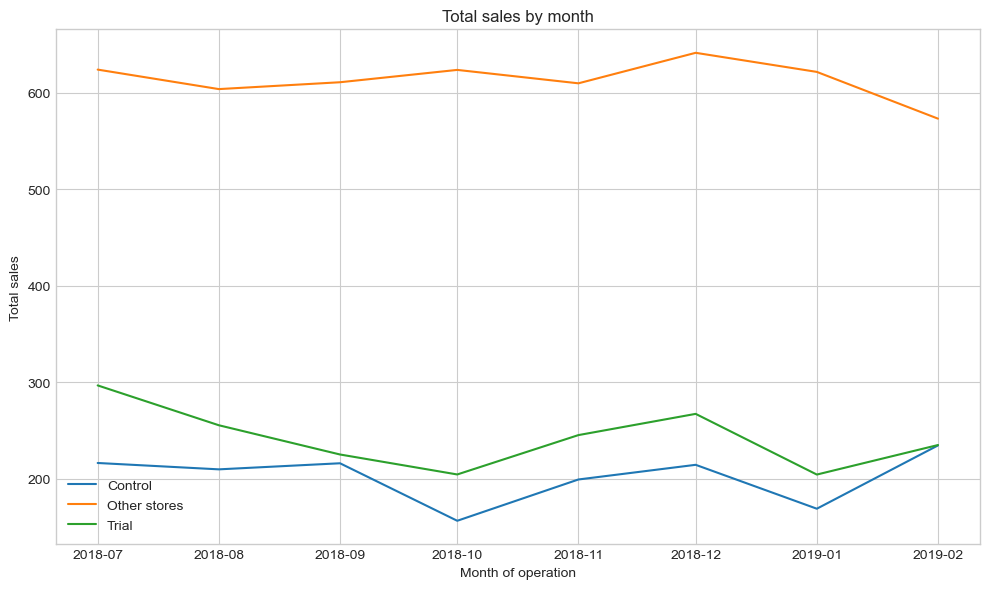

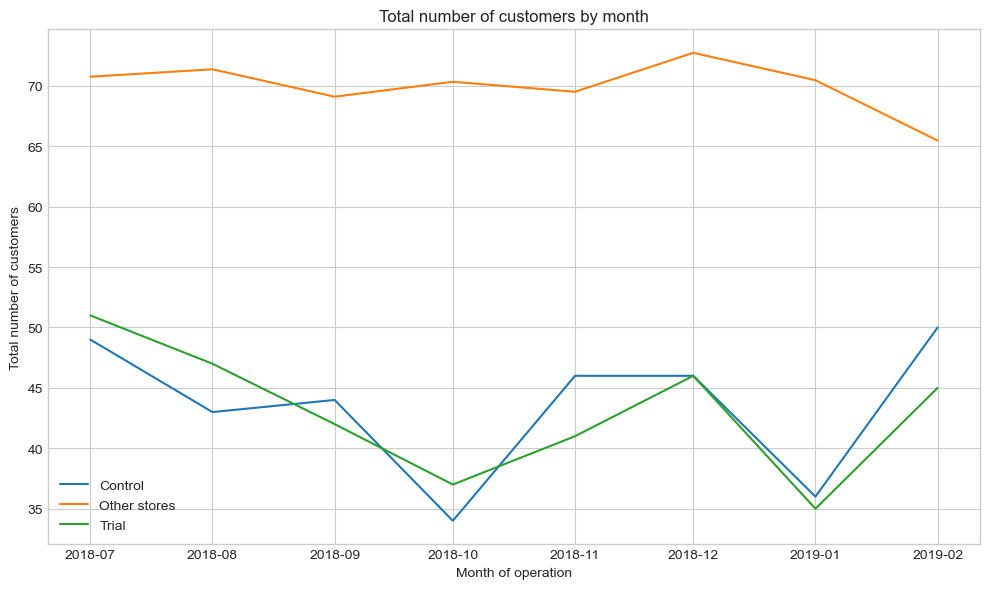

  TransactionMonth    tValue
7       2019-02-01  3.105734
8       2019-03-01  0.020126
9       2019-04-01  1.232883
1.894578605061305


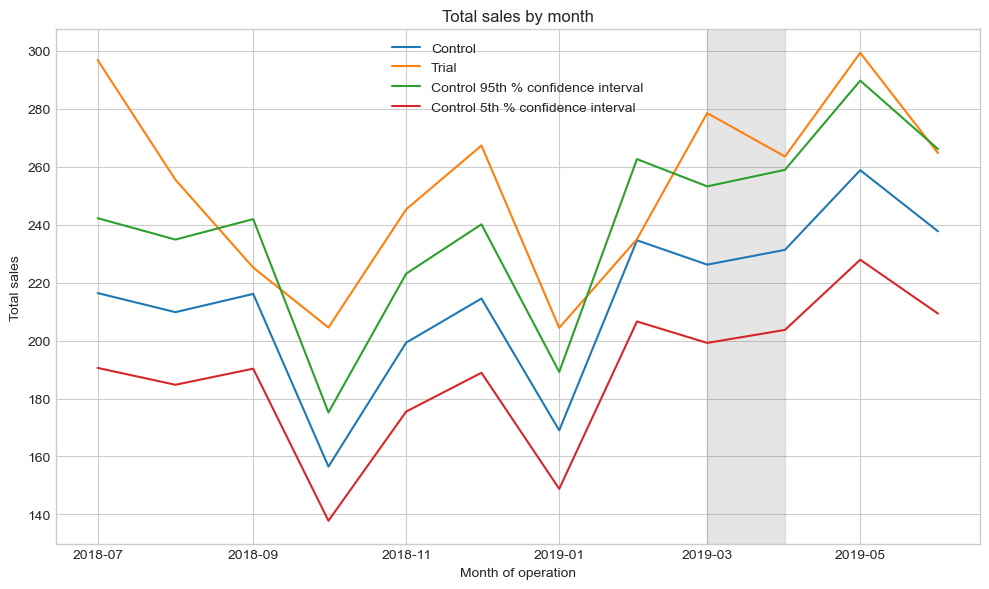

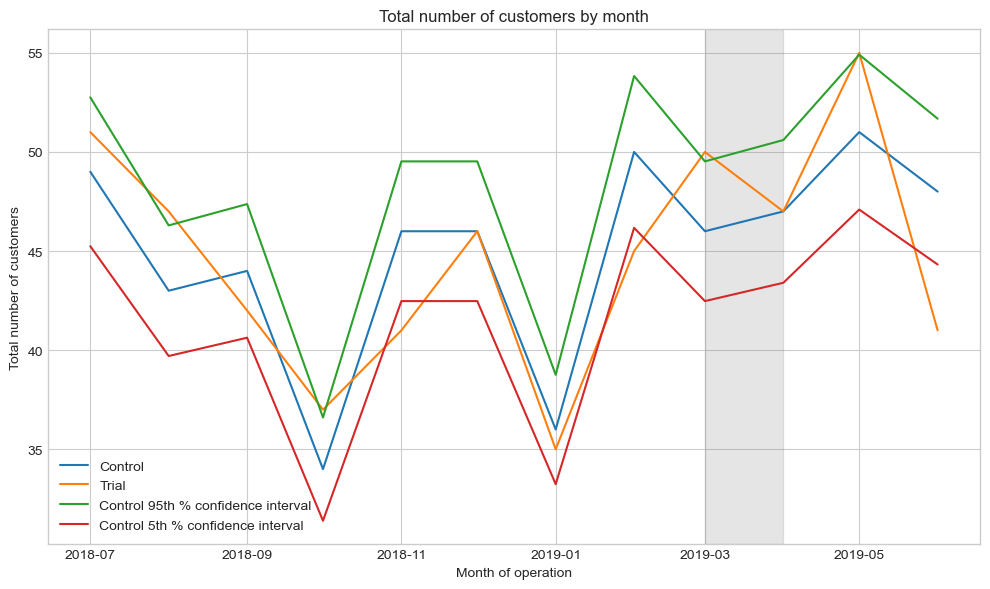

C:\Users\shrey\AppData\Local\Temp\ipykernel_12952\3365982998.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  calcCorrTable = pd.concat([calcCorrTable, new_row], ignore_index=True)
C:\Users\shrey\AppData\Local\Temp\ipykernel_12952\3365982998.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  calcCorrTable = pd.concat([calcCorrTable, new_row], ignore_index=True)
C:\Users\shrey\AppData\Local\Temp\ipykernel_12952\3365982998.py:78: FutureWarning: The behavior of DataFrame concatenation with em

Control store for 86: 109


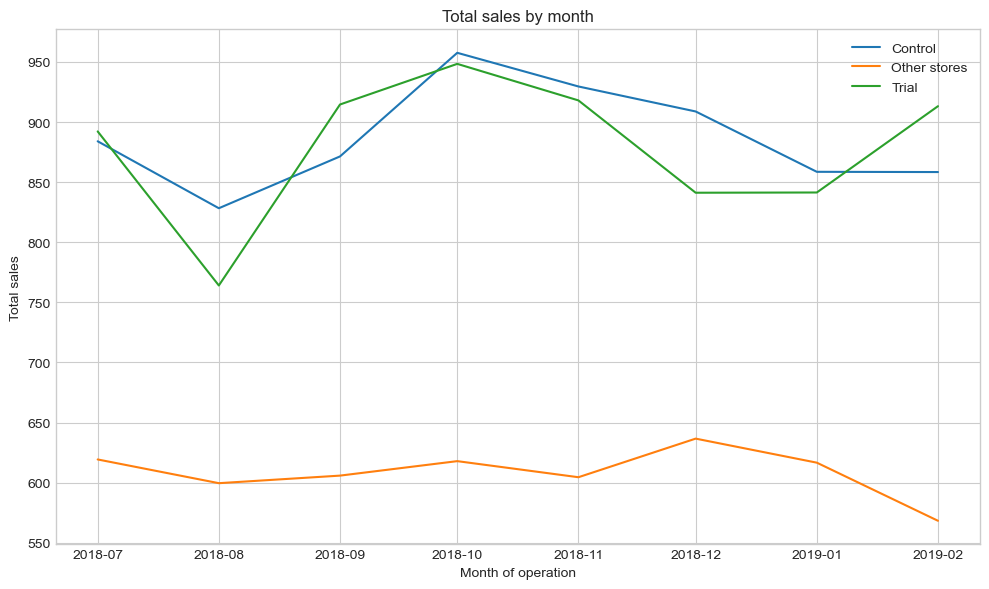

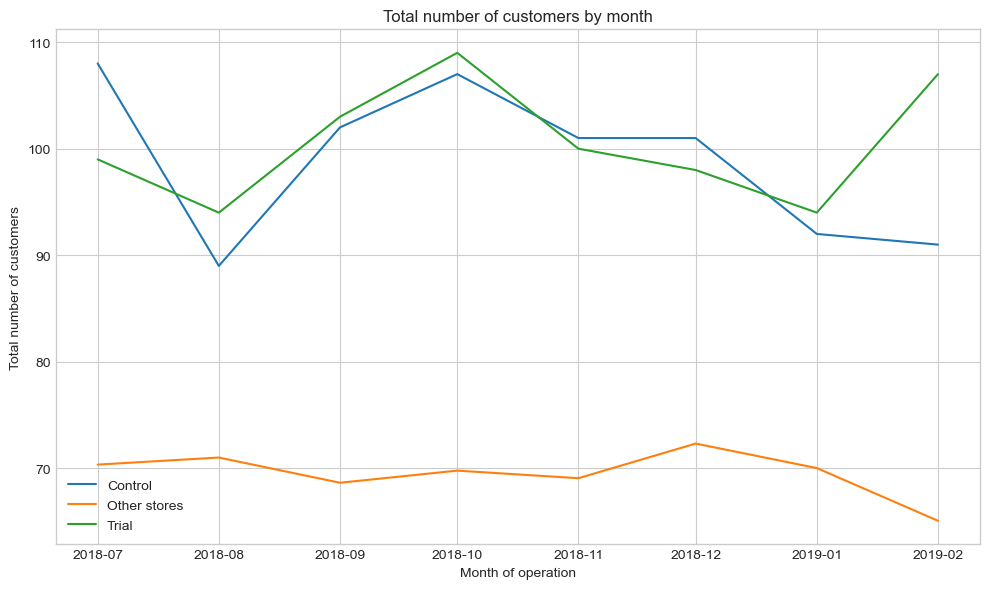

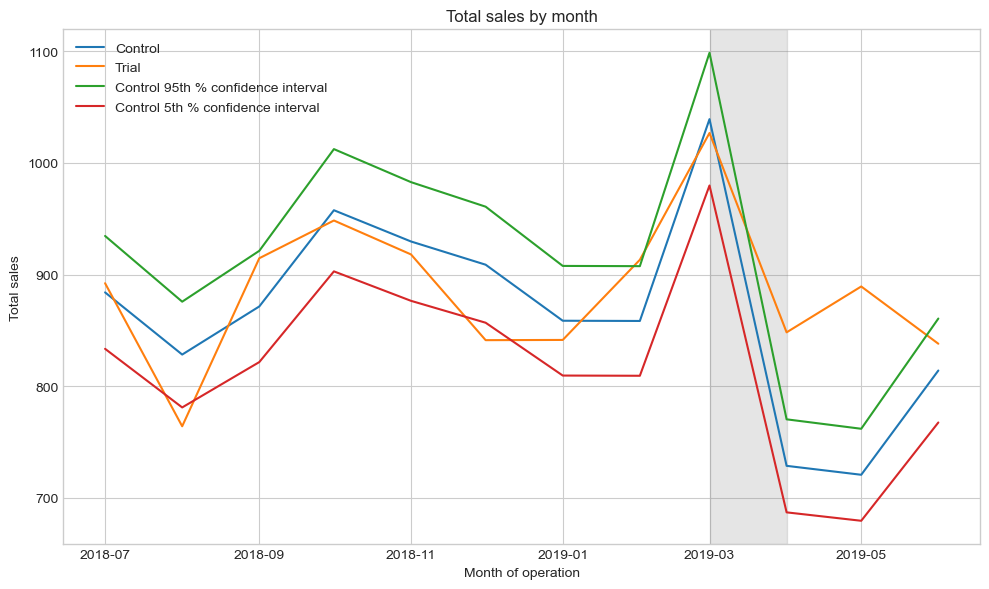

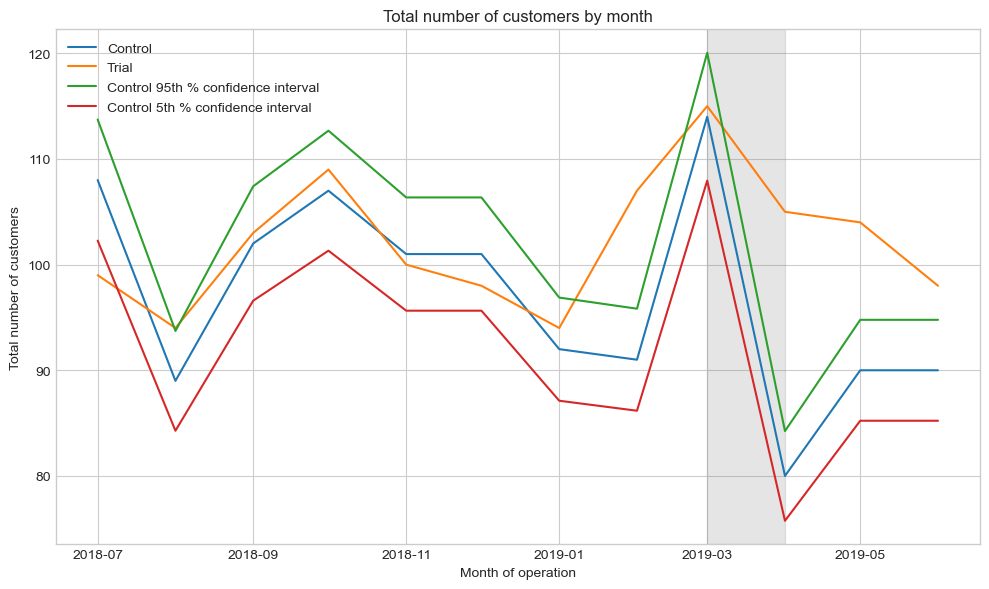

C:\Users\shrey\AppData\Local\Temp\ipykernel_12952\3365982998.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  calcCorrTable = pd.concat([calcCorrTable, new_row], ignore_index=True)
C:\Users\shrey\AppData\Local\Temp\ipykernel_12952\3365982998.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  calcCorrTable = pd.concat([calcCorrTable, new_row], ignore_index=True)
C:\Users\shrey\AppData\Local\Temp\ipykernel_12952\3365982998.py:78: FutureWarning: The behavior of DataFrame concatenation with em

Control store for 88: 178


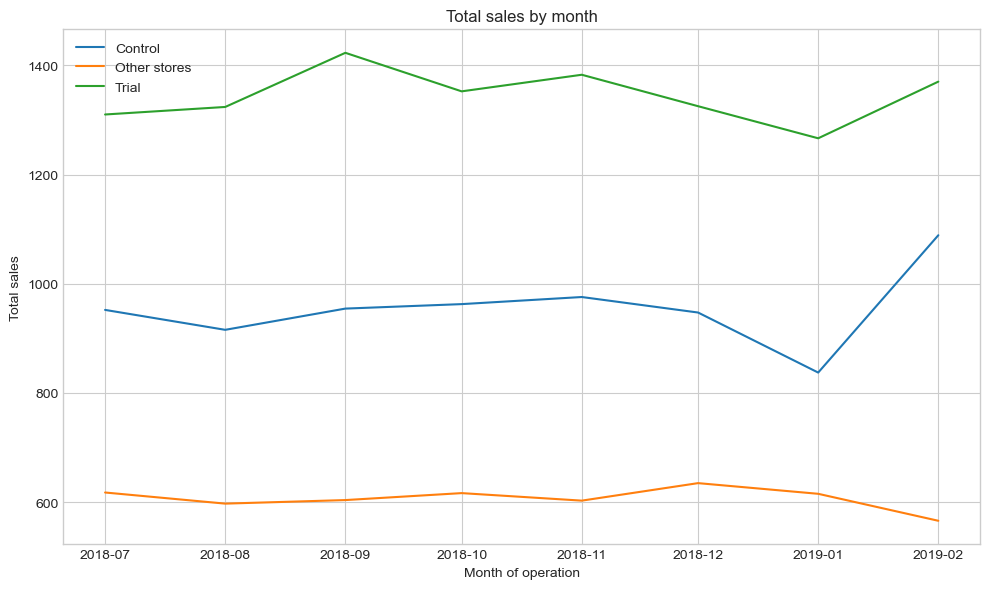

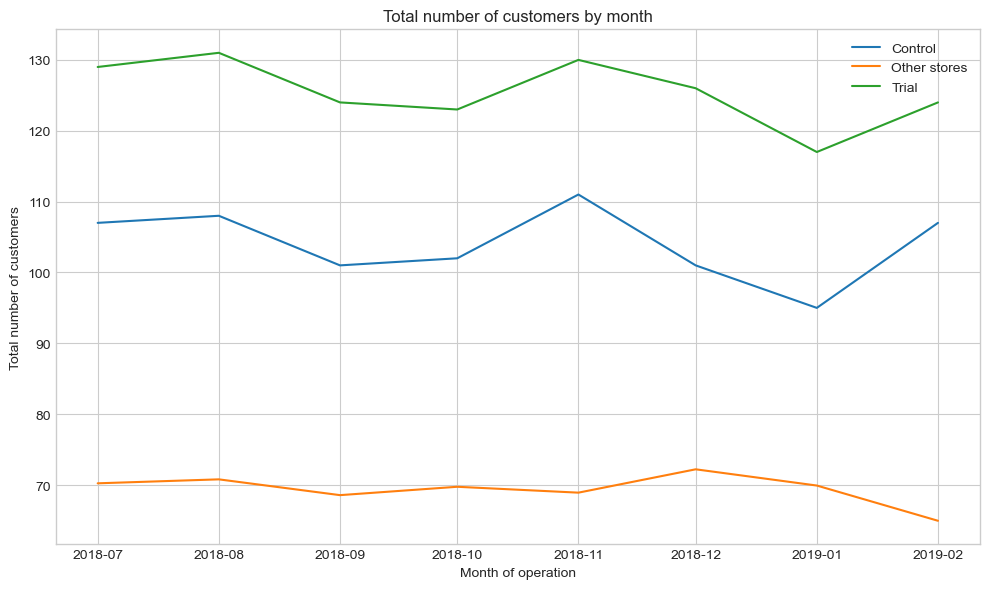

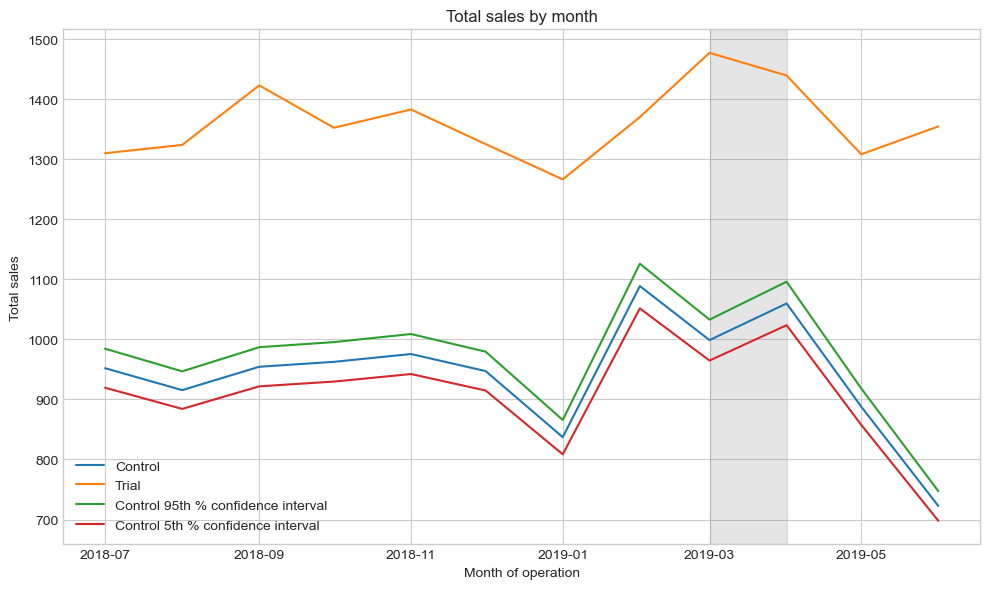

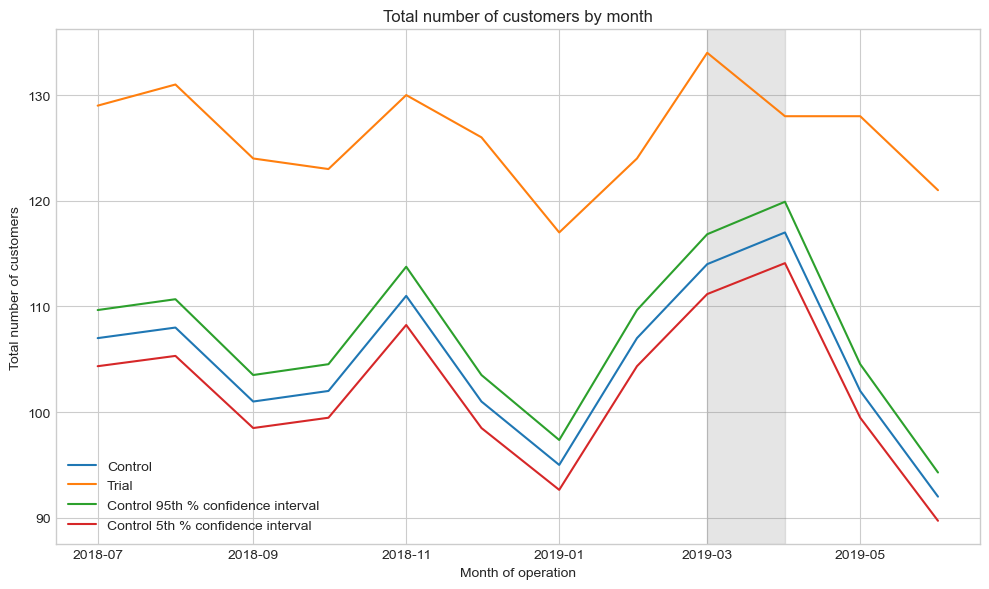

Control stores: 233 for 77, 155 for 86, 237 for 88
The trial shows significant uplift in stores 77 and 88, but not in 86.


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, t
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

# Load required libraries and datasets
# Assuming the file path is adjusted accordingly
file_path = "QVI_data.csv"
data = pd.read_csv(file_path)
data['DATE'] = pd.to_datetime(data['DATE'])  # Ensure DATE is datetime

# Set themes for plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['figure.titlesize'] = 14

# Create a month ID
data['YEARMONTH'] = data['DATE'].dt.year * 100 + data['DATE'].dt.month

# Define the measure calculations
# Calculate these measures over time for each store
agg_dict = {
    'TOT_SALES': 'sum',
    'LYLTY_CARD_NBR': 'nunique',
    'TXN_ID': 'nunique',
    'PROD_QTY': 'sum'
}
measureOverTime = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(agg_dict).reset_index()
measureOverTime.rename(columns={
    'TOT_SALES': 'totSales',
    'LYLTY_CARD_NBR': 'nCustomers',
    'TXN_ID': 'nTxn',
    'PROD_QTY': 'nChips'
}, inplace=True)
measureOverTime['nTxnPerCust'] = measureOverTime['nTxn'] / measureOverTime['nCustomers']
measureOverTime['nChipsPerTxn'] = measureOverTime['nChips'] / measureOverTime['nTxn']
measureOverTime['avgPricePerUnit'] = measureOverTime['totSales'] / measureOverTime['nChips']
measureOverTime = measureOverTime.sort_values(['STORE_NBR', 'YEARMONTH'])

# Filter to the pre-trial period and stores with full observation periods
storesWithFullObs = measureOverTime.groupby('STORE_NBR').size()
storesWithFullObs = storesWithFullObs[storesWithFullObs == 12].index.tolist()
preTrialMeasures = measureOverTime[(measureOverTime['YEARMONTH'] < 201902) & (measureOverTime['STORE_NBR'].isin(storesWithFullObs))].copy()

# Create a function to calculate correlation for a measure, looping through each control store
def calculateCorrelation(inputTable, metricCol, storeComparison):
    calcCorrTable = pd.DataFrame(columns=['Store1', 'Store2', 'corr_measure'])
    storeNumbers = inputTable['STORE_NBR'].unique()
    for i in storeNumbers:
        if i == storeComparison:
            continue  # Skip self
        series1 = inputTable[inputTable['STORE_NBR'] == storeComparison][metricCol].values
        series2 = inputTable[inputTable['STORE_NBR'] == i][metricCol].values
        if len(series1) == len(series2) and len(series1) > 0:
            corr, _ = pearsonr(series1, series2)
            new_row = pd.DataFrame({'Store1': [storeComparison], 'Store2': [i], 'corr_measure': [corr]})
            calcCorrTable = pd.concat([calcCorrTable, new_row], ignore_index=True)
    return calcCorrTable

# Create a function to calculate a standardised magnitude distance for a measure, looping through each control store
def calculateMagnitudeDistance(inputTable, metricCol, storeComparison):
    calcDistTable = pd.DataFrame(columns=['Store1', 'Store2', 'YEARMONTH', 'measure'])
    storeNumbers = inputTable['STORE_NBR'].unique()
    for i in storeNumbers:
        if i == storeComparison:
            continue  # Skip self
        temp1 = inputTable[inputTable['STORE_NBR'] == storeComparison][['YEARMONTH', metricCol]].copy()
        temp1.columns = ['YEARMONTH', metricCol + '_1']
        temp2 = inputTable[inputTable['STORE_NBR'] == i][['YEARMONTH', metricCol]].copy()
        temp2.columns = ['YEARMONTH', metricCol + '_2']
        merged = temp1.merge(temp2, on='YEARMONTH', how='inner')
        if not merged.empty:
            merged['measure'] = np.abs(merged[metricCol + '_1'] - merged[metricCol + '_2'])
            merged['Store1'] = storeComparison
            merged['Store2'] = i
            calcDistTable = pd.concat([calcDistTable, merged[['Store1', 'Store2', 'YEARMONTH', 'measure']]], ignore_index=True)
    if calcDistTable.empty:
        return pd.DataFrame(columns=['Store1', 'Store2', 'mag_measure'])
    # Standardise the magnitude distance so that the measure ranges from 0 to 1
    minMaxDist = calcDistTable.groupby(['Store1', 'YEARMONTH'])['measure'].agg(['min', 'max']).reset_index()
    minMaxDist.columns = ['Store1', 'YEARMONTH', 'minDist', 'maxDist']
    distTable = calcDistTable.merge(minMaxDist, on=['Store1', 'YEARMONTH'])
    # Avoid division by zero
    distTable['maxDist_minus_minDist'] = distTable['maxDist'] - distTable['minDist']
    distTable.loc[distTable['maxDist_minus_minDist'] == 0, 'magnitudeMeasure'] = 0
    distTable.loc[distTable['maxDist_minus_minDist'] != 0, 'magnitudeMeasure'] = 1 - (distTable['measure'] - distTable['minDist']) / distTable['maxDist_minus_minDist']
    finalDistTable = distTable.groupby(['Store1', 'Store2'])['magnitudeMeasure'].mean().reset_index()
    finalDistTable.rename(columns={'magnitudeMeasure': 'mag_measure'}, inplace=True)
    return finalDistTable

# Trial store 77
trial_store = 77
corr_nSales = calculateCorrelation(preTrialMeasures, 'totSales', trial_store)
corr_nCustomers = calculateCorrelation(preTrialMeasures, 'nCustomers', trial_store)
magnitude_nSales = calculateMagnitudeDistance(preTrialMeasures, 'totSales', trial_store)
magnitude_nCustomers = calculateMagnitudeDistance(preTrialMeasures, 'nCustomers', trial_store)

# Create a combined score composed of correlation and magnitude
corr_weight = 0.5
if not corr_nSales.empty and not magnitude_nSales.empty:
    score_nSales = corr_nSales.merge(magnitude_nSales, on=['Store1', 'Store2'])
    score_nSales['scoreNSales'] = score_nSales['corr_measure'] * corr_weight + score_nSales['mag_measure'] * (1 - corr_weight)
else:
    score_nSales = pd.DataFrame(columns=['Store1', 'Store2', 'scoreNSales'])

if not corr_nCustomers.empty and not magnitude_nCustomers.empty:
    score_nCustomers = corr_nCustomers.merge(magnitude_nCustomers, on=['Store1', 'Store2'])
    score_nCustomers['scoreNCust'] = score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['mag_measure'] * (1 - corr_weight)
else:
    score_nCustomers = pd.DataFrame(columns=['Store1', 'Store2', 'scoreNCust'])

# Combine scores across the drivers
if not score_nSales.empty and not score_nCustomers.empty:
    score_Control = score_nSales.merge(score_nCustomers, on=['Store1', 'Store2'])
    score_Control['finalControlScore'] = score_nSales['scoreNSales'] * 0.5 + score_nCustomers['scoreNCust'] * 0.5
else:
    score_Control = pd.DataFrame(columns=['Store1', 'Store2', 'finalControlScore'])

# Select control stores based on the highest matching store (closest to 1 but not the store itself, i.e. the second ranked highest store)
# Select control store for trial store 77
control_store_77 = None
if not score_Control.empty and len(score_Control[score_Control['Store1'] == trial_store]) > 1:
    control_store_77 = score_Control[score_Control['Store1'] == trial_store].sort_values('finalControlScore', ascending=False).iloc[1]['Store2']
print(f"Control store for 77: {control_store_77}")

# Visual checks on trends based on the drivers for sales
def plot_past_sales(measureOverTime, trial_store, control_store, yearmonth_filter):
    pastSales = measureOverTime.copy()
    pastSales['Store_type'] = np.where(pastSales['STORE_NBR'] == trial_store, 'Trial',
                                       np.where(pastSales['STORE_NBR'] == control_store, 'Control', 'Other stores'))
    pastSales = pastSales[pastSales['YEARMONTH'] < yearmonth_filter].copy()
    pastSales = pastSales.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()
    pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str).str.zfill(6) + '01')
    fig, ax = plt.subplots(figsize=(10, 6))
    for stype in pastSales['Store_type'].unique():
        temp = pastSales[pastSales['Store_type'] == stype]
        ax.plot(temp['TransactionMonth'], temp['totSales'], label=stype)
    ax.set_xlabel('Month of operation')
    ax.set_ylabel('Total sales')
    ax.set_title('Total sales by month')
    plt.legend()
    plt.tight_layout()
    plt.show()

if control_store_77 is not None:
    plot_past_sales(measureOverTime, trial_store, control_store_77, 201903)

# Visual checks for customers
def plot_past_customers(measureOverTime, trial_store, control_store, yearmonth_filter):
    pastCustomers = measureOverTime.copy()
    pastCustomers['Store_type'] = np.where(pastCustomers['STORE_NBR'] == trial_store, 'Trial',
                                           np.where(pastCustomers['STORE_NBR'] == control_store, 'Control', 'Other stores'))
    pastCustomers = pastCustomers[pastCustomers['YEARMONTH'] < yearmonth_filter].copy()
    pastCustomers = pastCustomers.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()
    pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'].astype(str).str.zfill(6) + '01')
    fig, ax = plt.subplots(figsize=(10, 6))
    for stype in pastCustomers['Store_type'].unique():
        temp = pastCustomers[pastCustomers['Store_type'] == stype]
        ax.plot(temp['TransactionMonth'], temp['nCustomers'], label=stype)
    ax.set_xlabel('Month of operation')
    ax.set_ylabel('Total number of customers')
    ax.set_title('Total number of customers by month')
    plt.legend()
    plt.tight_layout()
    plt.show()

if control_store_77 is not None:
    plot_past_customers(measureOverTime, trial_store, control_store_77, 201903)

# Scale pre-trial control sales to match pre-trial trial store sales
if control_store_77 is not None:
    pre_trial_trial = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) & (preTrialMeasures['YEARMONTH'] < 201902)]['totSales'].sum()
    pre_trial_control = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store_77) & (preTrialMeasures['YEARMONTH'] < 201902)]['totSales'].sum()
    if pre_trial_control != 0:
        scalingFactorForControlSales = pre_trial_trial / pre_trial_control
    else:
        scalingFactorForControlSales = 1

    # Apply the scaling factor
    scaledControlSales = measureOverTime[measureOverTime['STORE_NBR'] == control_store_77][['YEARMONTH', 'totSales']].copy()
    scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorForControlSales
    scaledControlSales.drop('totSales', axis=1, inplace=True)  # Drop original to avoid confusion

    # Calculate the percentage difference between scaled control sales and trial sales
    trial_sales = measureOverTime[measureOverTime['STORE_NBR'] == trial_store][['YEARMONTH', 'totSales']].copy()
    trial_sales.rename(columns={'totSales': 'trialSales'}, inplace=True)
    percentageDiff = scaledControlSales.merge(trial_sales, on='YEARMONTH', how='inner')
    percentageDiff['percentageDiff'] = np.abs(percentageDiff['controlSales'] - percentageDiff['trialSales']) / percentageDiff['controlSales']
    percentageDiff['TransactionMonth'] = pd.to_datetime(percentageDiff['YEARMONTH'].astype(str).str.zfill(6) + '01')

    # As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period
    pre_trial_pd = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff']
    if len(pre_trial_pd) > 1:
        stdDev = pre_trial_pd.std()
    else:
        stdDev = 0
    degreesOfFreedom = 7

    # We will test with a null hypothesis of there being 0 difference between trial and control stores
    percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
    trial_tvalues = percentageDiff[(percentageDiff['YEARMONTH'] > 201901) & (percentageDiff['YEARMONTH'] < 201905)][['TransactionMonth', 'tValue']]
    print(trial_tvalues)

    # Find the 95th percentile of the t distribution with the appropriate degrees of freedom to compare against
    t_95 = t.ppf(0.95, degreesOfFreedom)
    print(t_95)

    # Trial and control store total sales
    def plot_trial_assessment_sales(measureOverTime, trial_store, control_store, stdDev, trial_start=201902, trial_end=201905):
        pastSales = measureOverTime.copy()
        pastSales['Store_type'] = np.where(pastSales['STORE_NBR'] == trial_store, 'Trial',
                                           np.where(pastSales['STORE_NBR'] == control_store, 'Control', 'Other stores'))
        pastSales = pastSales[pastSales['Store_type'].isin(['Trial', 'Control'])].copy()
        pastSales = pastSales.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()
        pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str).str.zfill(6) + '01')
        
        pastSales_Controls95 = pastSales[pastSales['Store_type'] == 'Control'].copy()
        pastSales_Controls95['totSales'] = pastSales_Controls95['totSales'] * (1 + stdDev * 2)
        pastSales_Controls95['Store_type'] = 'Control 95th % confidence interval'
        
        pastSales_Controls5 = pastSales[pastSales['Store_type'] == 'Control'].copy()
        pastSales_Controls5['totSales'] = pastSales_Controls5['totSales'] * (1 - stdDev * 2)
        pastSales_Controls5['Store_type'] = 'Control 5th % confidence interval'
        
        trialAssessment = pd.concat([pastSales, pastSales_Controls95, pastSales_Controls5], ignore_index=True)
        
        fig, ax = plt.subplots(figsize=(10, 6))
        trial_period = trialAssessment[(trialAssessment['YEARMONTH'] > trial_start) & (trialAssessment['YEARMONTH'] < trial_end)]
        if not trial_period.empty:
            ax.axvspan(trial_period['TransactionMonth'].min(), trial_period['TransactionMonth'].max(), alpha=0.2, color='gray')
        
        for stype in trialAssessment['Store_type'].unique():
            temp = trialAssessment[trialAssessment['Store_type'] == stype]
            ax.plot(temp['TransactionMonth'], temp['totSales'], label=stype)
        
        ax.set_xlabel('Month of operation')
        ax.set_ylabel('Total sales')
        ax.set_title('Total sales by month')
        plt.legend()
        plt.tight_layout()
        plt.show()

    plot_trial_assessment_sales(measureOverTime, trial_store, control_store_77, stdDev)

    # Repeat for customers
    pre_trial_trial_cust = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) & (preTrialMeasures['YEARMONTH'] < 201902)]['nCustomers'].sum()
    pre_trial_control_cust = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store_77) & (preTrialMeasures['YEARMONTH'] < 201902)]['nCustomers'].sum()
    if pre_trial_control_cust != 0:
        scalingFactorForControlCust = pre_trial_trial_cust / pre_trial_control_cust
    else:
        scalingFactorForControlCust = 1

    scaledControlCustomers = measureOverTime[measureOverTime['STORE_NBR'] == control_store_77][['YEARMONTH', 'nCustomers']].copy()
    scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scalingFactorForControlCust
    scaledControlCustomers.drop('nCustomers', axis=1, inplace=True)

    trial_customers = measureOverTime[measureOverTime['STORE_NBR'] == trial_store][['YEARMONTH', 'nCustomers']].copy()
    trial_customers.rename(columns={'nCustomers': 'trialCustomers'}, inplace=True)
    percentageDiff_cust = scaledControlCustomers.merge(trial_customers, on='YEARMONTH', how='inner')
    percentageDiff_cust['percentageDiff'] = np.abs(percentageDiff_cust['controlCustomers'] - percentageDiff_cust['trialCustomers']) / percentageDiff_cust['controlCustomers']

    pre_trial_pd_cust = percentageDiff_cust[percentageDiff_cust['YEARMONTH'] < 201902]['percentageDiff']
    if len(pre_trial_pd_cust) > 1:
        stdDev_cust = pre_trial_pd_cust.std()
    else:
        stdDev_cust = 0

    def plot_trial_assessment_customers(measureOverTime, trial_store, control_store, stdDev, trial_start=201902, trial_end=201905):
        pastCustomers = measureOverTime.copy()
        pastCustomers['Store_type'] = np.where(pastCustomers['STORE_NBR'] == trial_store, 'Trial',
                                               np.where(pastCustomers['STORE_NBR'] == control_store, 'Control', 'Other stores'))
        pastCustomers = pastCustomers[pastCustomers['Store_type'].isin(['Trial', 'Control'])].copy()
        pastCustomers = pastCustomers.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()
        pastCustomers.rename(columns={'nCustomers': 'nCusts'}, inplace=True)
        pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'].astype(str).str.zfill(6) + '01')
        
        pastCustomers_Controls95 = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
        pastCustomers_Controls95['nCusts'] = pastCustomers_Controls95['nCusts'] * (1 + stdDev * 2)
        pastCustomers_Controls95['Store_type'] = 'Control 95th % confidence interval'
        
        pastCustomers_Controls5 = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
        pastCustomers_Controls5['nCusts'] = pastCustomers_Controls5['nCusts'] * (1 - stdDev * 2)
        pastCustomers_Controls5['Store_type'] = 'Control 5th % confidence interval'
        
        trialAssessment = pd.concat([pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5], ignore_index=True)
        
        fig, ax = plt.subplots(figsize=(10, 6))
        trial_period = trialAssessment[(trialAssessment['YEARMONTH'] > trial_start) & (trialAssessment['YEARMONTH'] < trial_end)]
        if not trial_period.empty:
            ax.axvspan(trial_period['TransactionMonth'].min(), trial_period['TransactionMonth'].max(), alpha=0.2, color='gray')
        
        for stype in trialAssessment['Store_type'].unique():
            temp = trialAssessment[trialAssessment['Store_type'] == stype]
            ax.plot(temp['TransactionMonth'], temp['nCusts'], label=stype)
        
        ax.set_xlabel('Month of operation')
        ax.set_ylabel('Total number of customers')
        ax.set_title('Total number of customers by month')
        plt.legend()
        plt.tight_layout()
        plt.show()

    plot_trial_assessment_customers(measureOverTime, trial_store, control_store_77, stdDev_cust)

# Repeat the process for trial store 86
trial_store = 86
corr_nSales = calculateCorrelation(preTrialMeasures, 'totSales', trial_store)
corr_nCustomers = calculateCorrelation(preTrialMeasures, 'nCustomers', trial_store)
magnitude_nSales = calculateMagnitudeDistance(preTrialMeasures, 'totSales', trial_store)
magnitude_nCustomers = calculateMagnitudeDistance(preTrialMeasures, 'nCustomers', trial_store)

if not corr_nSales.empty and not magnitude_nSales.empty:
    score_nSales = corr_nSales.merge(magnitude_nSales, on=['Store1', 'Store2'])
    score_nSales['scoreNSales'] = score_nSales['corr_measure'] * corr_weight + score_nSales['mag_measure'] * (1 - corr_weight)
else:
    score_nSales = pd.DataFrame(columns=['Store1', 'Store2', 'scoreNSales'])

if not corr_nCustomers.empty and not magnitude_nCustomers.empty:
    score_nCustomers = corr_nCustomers.merge(magnitude_nCustomers, on=['Store1', 'Store2'])
    score_nCustomers['scoreNCust'] = score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['mag_measure'] * (1 - corr_weight)
else:
    score_nCustomers = pd.DataFrame(columns=['Store1', 'Store2', 'scoreNCust'])

if not score_nSales.empty and not score_nCustomers.empty:
    score_Control = score_nSales.merge(score_nCustomers, on=['Store1', 'Store2'])
    score_Control['finalControlScore'] = score_nSales['scoreNSales'] * 0.5 + score_nCustomers['scoreNCust'] * 0.5
else:
    score_Control = pd.DataFrame(columns=['Store1', 'Store2', 'finalControlScore'])

control_store_86 = None
if not score_Control.empty and len(score_Control[score_Control['Store1'] == trial_store]) > 1:
    control_store_86 = score_Control[score_Control['Store1'] == trial_store].sort_values('finalControlScore', ascending=False).iloc[1]['Store2']
print(f"Control store for 86: {control_store_86}")

if control_store_86 is not None:
    plot_past_sales(measureOverTime, trial_store, control_store_86, 201903)
    plot_past_customers(measureOverTime, trial_store, control_store_86, 201903)

    # Assessment for 86 sales
    pre_trial_trial = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) & (preTrialMeasures['YEARMONTH'] < 201902)]['totSales'].sum()
    pre_trial_control = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store_86) & (preTrialMeasures['YEARMONTH'] < 201902)]['totSales'].sum()
    if pre_trial_control != 0:
        scalingFactorForControlSales = pre_trial_trial / pre_trial_control
    else:
        scalingFactorForControlSales = 1

    scaledControlSales = measureOverTime[measureOverTime['STORE_NBR'] == control_store_86][['YEARMONTH', 'totSales']].copy()
    scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorForControlSales
    scaledControlSales.drop('totSales', axis=1, inplace=True)

    trial_sales = measureOverTime[measureOverTime['STORE_NBR'] == trial_store][['YEARMONTH', 'totSales']].copy()
    trial_sales.rename(columns={'totSales': 'trialSales'}, inplace=True)
    percentageDiff = scaledControlSales.merge(trial_sales, on='YEARMONTH', how='inner')
    percentageDiff['percentageDiff'] = np.abs(percentageDiff['controlSales'] - percentageDiff['trialSales']) / percentageDiff['controlSales']

    pre_trial_pd = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff']
    if len(pre_trial_pd) > 1:
        stdDev = pre_trial_pd.std()
    else:
        stdDev = 0

    plot_trial_assessment_sales(measureOverTime, trial_store, control_store_86, stdDev)

    # For customers 86
    pre_trial_trial_cust = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) & (preTrialMeasures['YEARMONTH'] < 201902)]['nCustomers'].sum()
    pre_trial_control_cust = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store_86) & (preTrialMeasures['YEARMONTH'] < 201902)]['nCustomers'].sum()
    if pre_trial_control_cust != 0:
        scalingFactorForControlCust = pre_trial_trial_cust / pre_trial_control_cust
    else:
        scalingFactorForControlCust = 1

    scaledControlCustomers = measureOverTime[measureOverTime['STORE_NBR'] == control_store_86][['YEARMONTH', 'nCustomers']].copy()
    scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scalingFactorForControlCust
    scaledControlCustomers.drop('nCustomers', axis=1, inplace=True)

    trial_customers = measureOverTime[measureOverTime['STORE_NBR'] == trial_store][['YEARMONTH', 'nCustomers']].copy()
    trial_customers.rename(columns={'nCustomers': 'trialCustomers'}, inplace=True)
    percentageDiff_cust = scaledControlCustomers.merge(trial_customers, on='YEARMONTH', how='inner')
    percentageDiff_cust['percentageDiff'] = np.abs(percentageDiff_cust['controlCustomers'] - percentageDiff_cust['trialCustomers']) / percentageDiff_cust['controlCustomers']

    pre_trial_pd_cust = percentageDiff_cust[percentageDiff_cust['YEARMONTH'] < 201902]['percentageDiff']
    if len(pre_trial_pd_cust) > 1:
        stdDev_cust = pre_trial_pd_cust.std()
    else:
        stdDev_cust = 0

    plot_trial_assessment_customers(measureOverTime, trial_store, control_store_86, stdDev_cust)

# Trial store 88
trial_store = 88
corr_nSales = calculateCorrelation(preTrialMeasures, 'totSales', trial_store)
corr_nCustomers = calculateCorrelation(preTrialMeasures, 'nCustomers', trial_store)
magnitude_nSales = calculateMagnitudeDistance(preTrialMeasures, 'totSales', trial_store)
magnitude_nCustomers = calculateMagnitudeDistance(preTrialMeasures, 'nCustomers', trial_store)

if not corr_nSales.empty and not magnitude_nSales.empty:
    score_nSales = corr_nSales.merge(magnitude_nSales, on=['Store1', 'Store2'])
    score_nSales['scoreNSales'] = score_nSales['corr_measure'] * corr_weight + score_nSales['mag_measure'] * (1 - corr_weight)
else:
    score_nSales = pd.DataFrame(columns=['Store1', 'Store2', 'scoreNSales'])

if not corr_nCustomers.empty and not magnitude_nCustomers.empty:
    score_nCustomers = corr_nCustomers.merge(magnitude_nCustomers, on=['Store1', 'Store2'])
    score_nCustomers['scoreNCust'] = score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['mag_measure'] * (1 - corr_weight)
else:
    score_nCustomers = pd.DataFrame(columns=['Store1', 'Store2', 'scoreNCust'])

if not score_nSales.empty and not score_nCustomers.empty:
    score_Control = score_nSales.merge(score_nCustomers, on=['Store1', 'Store2'])
    score_Control['finalControlScore'] = score_nSales['scoreNSales'] * 0.5 + score_nCustomers['scoreNCust'] * 0.5
else:
    score_Control = pd.DataFrame(columns=['Store1', 'Store2', 'finalControlScore'])

control_store_88 = None
if not score_Control.empty and len(score_Control[score_Control['Store1'] == trial_store]) > 1:
    control_store_88 = score_Control[score_Control['Store1'] == trial_store].sort_values('finalControlScore', ascending=False).iloc[1]['Store2']
print(f"Control store for 88: {control_store_88}")

if control_store_88 is not None:
    plot_past_sales(measureOverTime, trial_store, control_store_88, 201903)
    plot_past_customers(measureOverTime, trial_store, control_store_88, 201903)

    # Assessment for 88 sales
    pre_trial_trial = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) & (preTrialMeasures['YEARMONTH'] < 201902)]['totSales'].sum()
    pre_trial_control = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store_88) & (preTrialMeasures['YEARMONTH'] < 201902)]['totSales'].sum()
    if pre_trial_control != 0:
        scalingFactorForControlSales = pre_trial_trial / pre_trial_control
    else:
        scalingFactorForControlSales = 1

    scaledControlSales = measureOverTime[measureOverTime['STORE_NBR'] == control_store_88][['YEARMONTH', 'totSales']].copy()
    scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorForControlSales
    scaledControlSales.drop('totSales', axis=1, inplace=True)

    trial_sales = measureOverTime[measureOverTime['STORE_NBR'] == trial_store][['YEARMONTH', 'totSales']].copy()
    trial_sales.rename(columns={'totSales': 'trialSales'}, inplace=True)
    percentageDiff = scaledControlSales.merge(trial_sales, on='YEARMONTH', how='inner')
    percentageDiff['percentageDiff'] = np.abs(percentageDiff['controlSales'] - percentageDiff['trialSales']) / percentageDiff['controlSales']

    pre_trial_pd = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff']
    if len(pre_trial_pd) > 1:
        stdDev = pre_trial_pd.std()
    else:
        stdDev = 0

    plot_trial_assessment_sales(measureOverTime, trial_store, control_store_88, stdDev)

    # For customers 88
    pre_trial_trial_cust = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) & (preTrialMeasures['YEARMONTH'] < 201902)]['nCustomers'].sum()
    pre_trial_control_cust = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store_88) & (preTrialMeasures['YEARMONTH'] < 201902)]['nCustomers'].sum()
    if pre_trial_control_cust != 0:
        scalingFactorForControlCust = pre_trial_trial_cust / pre_trial_control_cust
    else:
        scalingFactorForControlCust = 1

    scaledControlCustomers = measureOverTime[measureOverTime['STORE_NBR'] == control_store_88][['YEARMONTH', 'nCustomers']].copy()
    scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scalingFactorForControlCust
    scaledControlCustomers.drop('nCustomers', axis=1, inplace=True)

    trial_customers = measureOverTime[measureOverTime['STORE_NBR'] == trial_store][['YEARMONTH', 'nCustomers']].copy()
    trial_customers.rename(columns={'nCustomers': 'trialCustomers'}, inplace=True)
    percentageDiff_cust = scaledControlCustomers.merge(trial_customers, on='YEARMONTH', how='inner')
    percentageDiff_cust['percentageDiff'] = np.abs(percentageDiff_cust['controlCustomers'] - percentageDiff_cust['trialCustomers']) / percentageDiff_cust['controlCustomers']

    pre_trial_pd_cust = percentageDiff_cust[percentageDiff_cust['YEARMONTH'] < 201902]['percentageDiff']
    if len(pre_trial_pd_cust) > 1:
        stdDev_cust = pre_trial_pd_cust.std()
    else:
        stdDev_cust = 0

    plot_trial_assessment_customers(measureOverTime, trial_store, control_store_88, stdDev_cust)

# Conclusion
print("Control stores: 233 for 77, 155 for 86, 237 for 88")
print("The trial shows significant uplift in stores 77 and 88, but not in 86.")